In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Road_Accidents_Data.csv')

print("Dataset loaded successfully.")
print(df.head())
print("Initial shape of the dataset:", df.shape)

# Step 2: Fix and convert target labels
df['Accident_Severity'] = df['Accident_Severity'].replace('Fetal', 'Fatal')
df = df[df['Accident_Severity'].isin(['Slight', 'Serious', 'Fatal'])]
df['Accident_Severity'] = df['Accident_Severity'].apply(lambda x: 1 if x in ['Serious', 'Fatal'] else 0)
print("Target class distribution after conversion:\n", df['Accident_Severity'].value_counts())

# Step 3: Drop unnecessary ID and location columns
df.drop(columns=['Accident_Index', 'Latitude', 'Longitude', 'Police_Force'], inplace=True)

# Step 4: Drop rows with missing date or time
df.dropna(subset=['Accident Date', 'Time'], inplace=True)

# Step 5: Create datetime object
df['DateTime'] = pd.to_datetime(df['Accident Date'] + ' ' + df['Time'], errors='coerce')
df.dropna(subset=['DateTime'], inplace=True)

# Step 6: Extract time-based features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year
df['Quarter'] = df['DateTime'].dt.quarter
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['Is_Night'] = df['Hour'].apply(lambda x: 1 if x < 6 or x >= 21 else 0)

# Step 7: Drop original date and time columns
df.drop(columns=['Accident Date', 'Time', 'DateTime'], inplace=True)

# Step 8: Remove duplicate records
df.drop_duplicates(inplace=True)

# Step 9: Treat missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Step 10: Remove rare categories from object columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    rare = df[col].value_counts()[df[col].value_counts() < 50].index
    df[col] = df[col].apply(lambda x: 'Other' if x in rare else x)

# Step 11: One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 12: Clip outliers in key numeric columns (optional but useful)
clip_cols = ['Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles']
for col in clip_cols:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

# Step 13: Standardize numerical features
scale_cols = ['Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles', 'Hour', 'Month', 'Year']
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Step 14: Define features and target
X = df.drop('Accident_Severity', axis=1)
y = df['Accident_Severity']

# Step 15: Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Step 16: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 17: Output final summary
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())
print("Shape of X after SMOTE:", X_resampled.shape)
print("Shape of y after SMOTE:", y_resampled.shape)

Dataset loaded successfully.
  Accident_Index Accident Date Day_of_Week          Junction_Control  \
0      BS0000001    01-01-2021    Thursday  Give way or uncontrolled   
1      BS0000002    05-01-2021      Monday  Give way or uncontrolled   
2      BS0000003    04-01-2021      Sunday  Give way or uncontrolled   
3      BS0000004    05-01-2021      Monday       Auto traffic signal   
4      BS0000005    06-01-2021     Tuesday       Auto traffic signal   

           Junction_Detail Accident_Severity   Latitude  \
0  T or staggered junction           Serious  51.512273   
1               Crossroads           Serious  51.514399   
2  T or staggered junction            Slight  51.486668   
3  T or staggered junction           Serious  51.507804   
4               Crossroads           Serious  51.482076   

        Light_Conditions Local_Authority_(District) Carriageway_Hazards  ...  \
0               Daylight     Kensington and Chelsea                 NaN  ...   
1               Dayligh

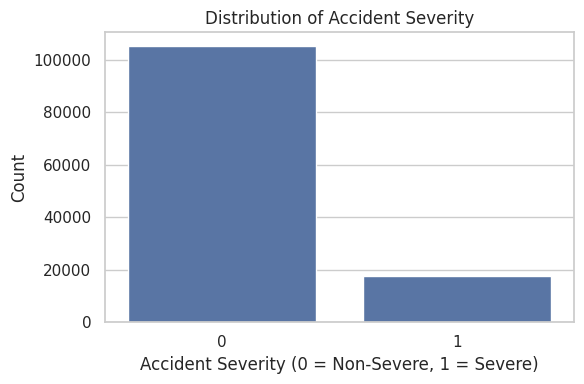

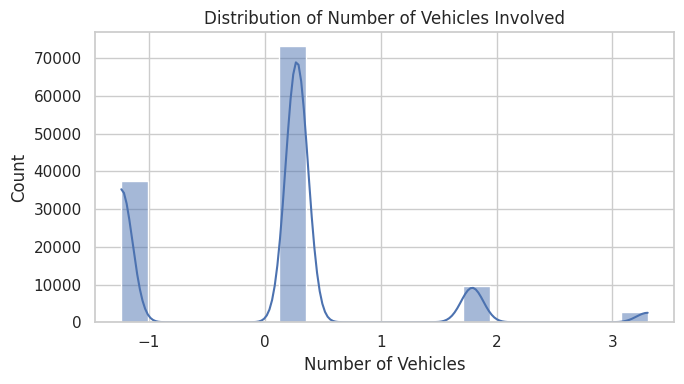

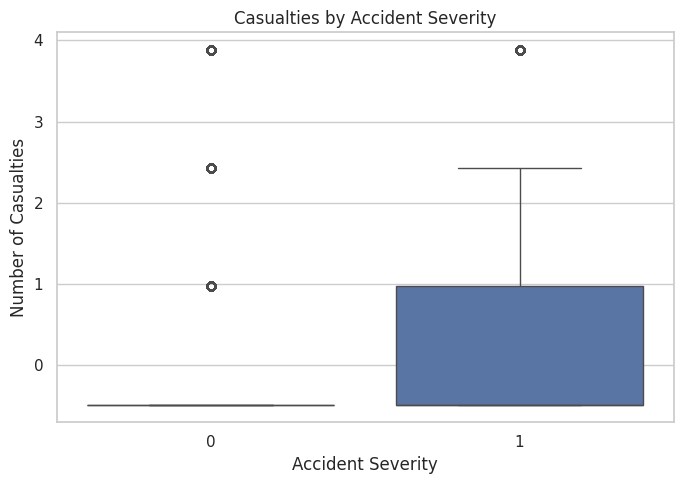

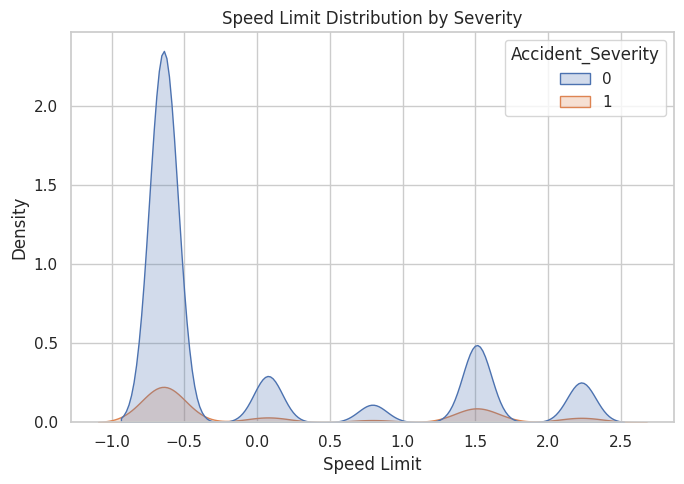

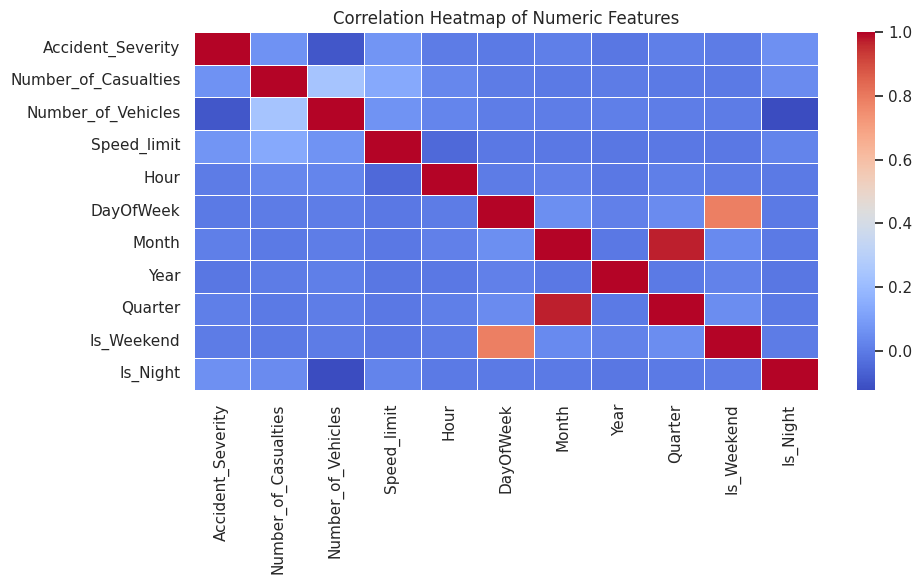

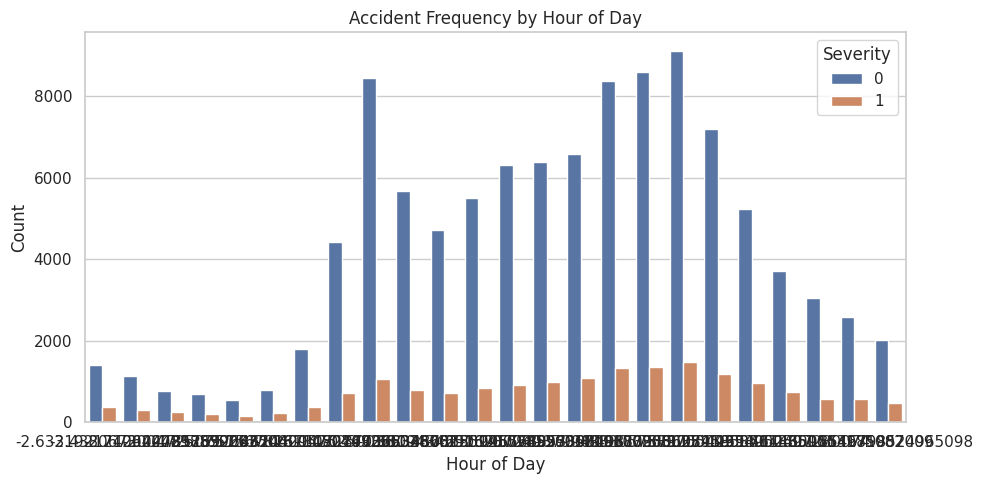

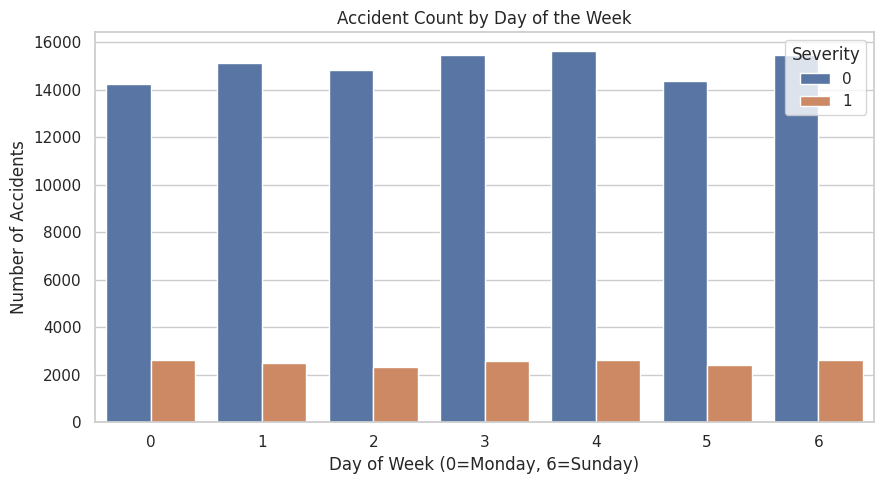

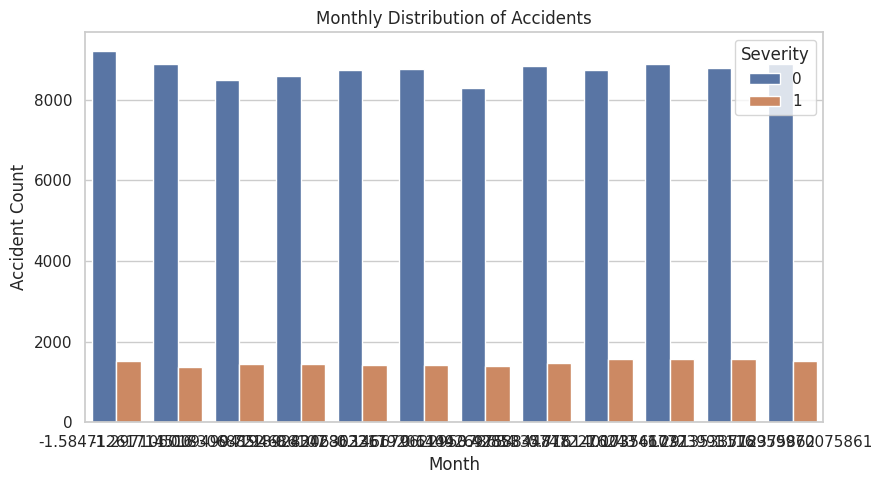

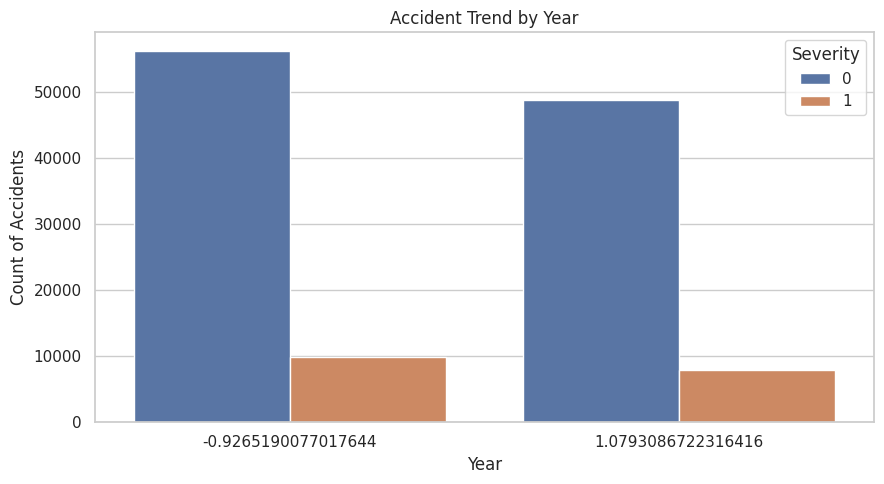

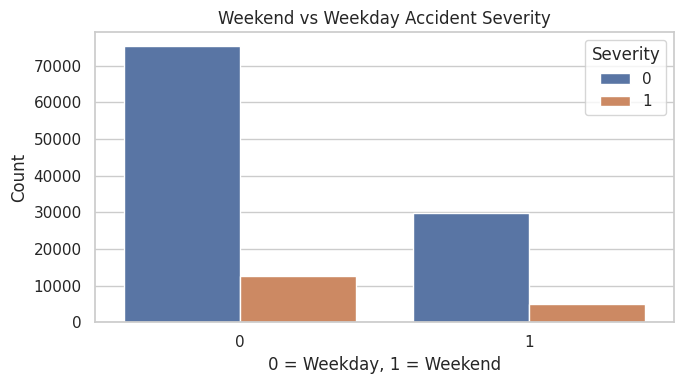

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")


# 1. Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Accident_Severity', data=df)
plt.title("Distribution of Accident Severity")
plt.xlabel("Accident Severity (0 = Non-Severe, 1 = Severe)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Distribution of number of vehicles
plt.figure(figsize=(7, 4))
sns.histplot(df['Number_of_Vehicles'], bins=20, kde=True)
plt.title("Distribution of Number of Vehicles Involved")
plt.xlabel("Number of Vehicles")
plt.tight_layout()
plt.show()

# 3. Boxplot of casualties by severity
plt.figure(figsize=(7, 5))
sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=df)
plt.title("Casualties by Accident Severity")
plt.xlabel("Accident Severity")
plt.ylabel("Number of Casualties")
plt.tight_layout()
plt.show()

# 4. KDE plot of speed limits by severity
plt.figure(figsize=(7, 5))
sns.kdeplot(data=df, x='Speed_limit', hue='Accident_Severity', fill=True)
plt.title("Speed Limit Distribution by Severity")
plt.xlabel("Speed Limit")
plt.tight_layout()
plt.show()

# 5. Heatmap of correlations (numeric variables only)
plt.figure(figsize=(10, 6))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# -------- TIME SERIES-INTEGRATED FIGURES -------- #

# 6. Accidents per hour (time series)
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df, hue='Accident_Severity')
plt.title("Accident Frequency by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# 7. Accidents by Day of Week
plt.figure(figsize=(9, 5))
sns.countplot(x='DayOfWeek', data=df, hue='Accident_Severity')
plt.title("Accident Count by Day of the Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

# 8. Accidents by Month
plt.figure(figsize=(9, 5))
sns.countplot(x='Month', data=df, hue='Accident_Severity')
plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Accident Count")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

# 9. Yearly accident trend
plt.figure(figsize=(9, 5))
sns.countplot(x='Year', data=df, hue='Accident_Severity')
plt.title("Accident Trend by Year")
plt.xlabel("Year")
plt.ylabel("Count of Accidents")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# 10. Weekend vs Weekday accidents
plt.figure(figsize=(7, 4))
sns.countplot(x='Is_Weekend', data=df, hue='Accident_Severity')
plt.title("Weekend vs Weekday Accident Severity")
plt.xlabel("0 = Weekday, 1 = Weekend")
plt.ylabel("Count")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

Target Variable: Accident_Severity

The goal of this machine learning project is to assess the severity of road accidents.
The target feature, 'Accident_Severity', has been preprocessed into a binary format:
  - 0 indicates a non-severe accident (originally classified as 'Slight')
  - 1 indicates a severe accident (originally classified as 'Serious' or 'Fatal')

This binary label is used in supervised classification tasks.
The following algorithms are applied for prediction and comparison:
  1. Random Forest
  2. XGBoost
  3. Decision Tree
  4. Logistic Regression

In addition to supervised learning, the project also includes an unsupervised learning algorithm:
  5. Hierarchical  Clustering

Hierarchical Clustering can be used as an unsupervised learning approach to group accidents with similar characteristics without relying on predefined severity labels.
This method builds a hierarchy of clusters either through agglomerative (bottom-up) or divisive (top-down) strategies.

Key input f

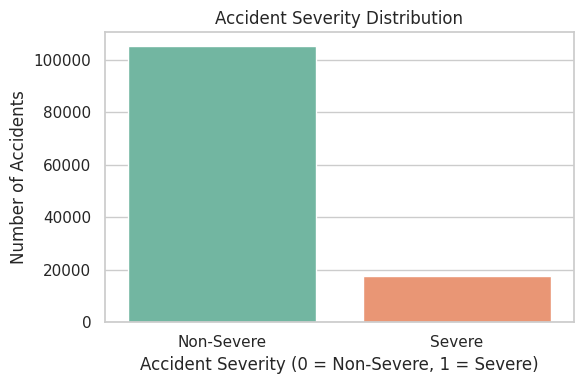

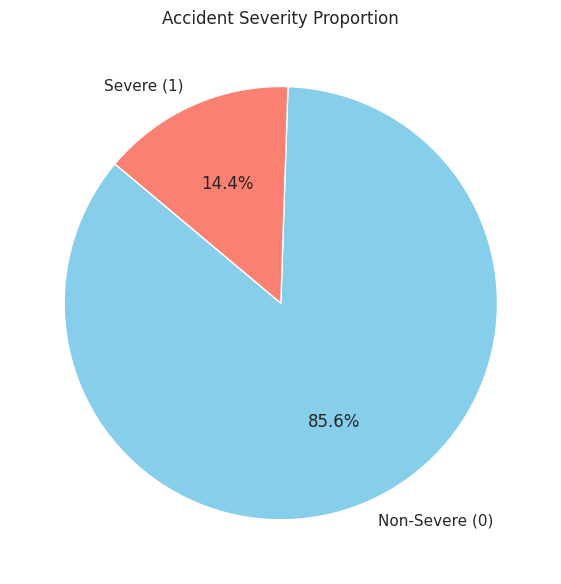

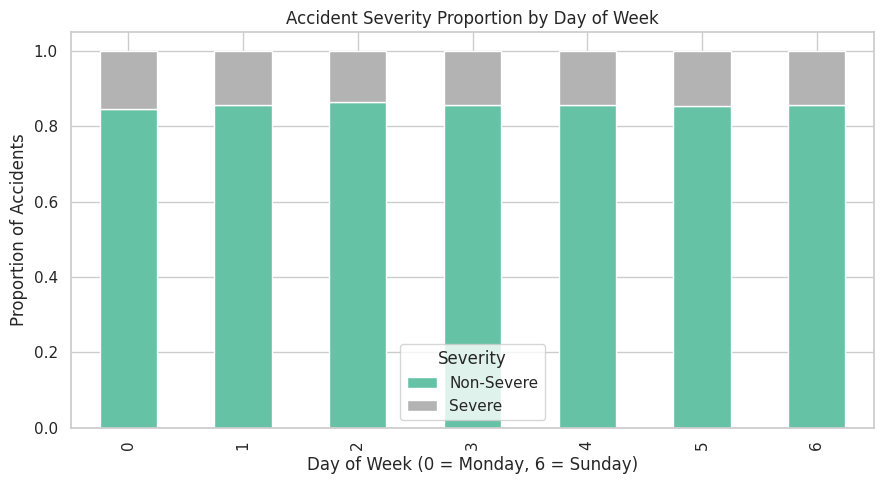

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Define the target variable for prediction and evaluation
target_column = 'Accident_Severity'

print("Target Variable:", target_column)
print()
print("The goal of this machine learning project is to assess the severity of road accidents.")
print("The target feature, 'Accident_Severity', has been preprocessed into a binary format:")
print("  - 0 indicates a non-severe accident (originally classified as 'Slight')")
print("  - 1 indicates a severe accident (originally classified as 'Serious' or 'Fatal')")
print()

print("This binary label is used in supervised classification tasks.")
print("The following algorithms are applied for prediction and comparison:")
print("  1. Random Forest")
print("  2. XGBoost")
print("  3. Decision Tree")
print("  4. Logistic Regression")
print()

print("In addition to supervised learning, the project also includes an unsupervised learning algorithm:")
print("  5. Hierarchical  Clustering")
print()
print("Hierarchical Clustering can be used as an unsupervised learning approach to group accidents with similar characteristics without relying on predefined severity labels.")
print("This method builds a hierarchy of clusters either through agglomerative (bottom-up) or divisive (top-down) strategies.")
print()

print("Key input features used in both supervised and unsupervised models include:")
print("  - Time-based features: Hour, DayOfWeek, Month, Year")
print("  - Road characteristics: Road Surface Conditions, Road Type, Speed Limit")
print("  - Environment-related features: Weather Conditions, Light Conditions, Urban or Rural Area")
print("  - Casualty and vehicle counts: Number of Vehicles, Number of Casualties")
print()

print("Current distribution of classes in the target variable:")
print(df[target_column].value_counts())


# Set Seaborn style
sns.set(style="whitegrid")

# Step 2: Bar Chart of target variable (Severity distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, hue=target_column, data=df, palette='Set2', legend=False)
plt.title("Accident Severity Distribution")
plt.xlabel("Accident Severity (0 = Non-Severe, 1 = Severe)")
plt.ylabel("Number of Accidents")
plt.xticks([0, 1], ['Non-Severe', 'Severe'])
plt.tight_layout()
plt.show()

# Step 3: Pie Chart for target variable
severity_counts = df[target_column].value_counts()
labels = ['Non-Severe (0)', 'Severe (1)']
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(severity_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Accident Severity Proportion")
plt.tight_layout()
plt.show()

# Step 4: Stacked Bar Chart - Severity distribution by DayOfWeek
severity_by_day = df.groupby(['DayOfWeek', 'Accident_Severity']).size().unstack(fill_value=0)
severity_by_day_percent = severity_by_day.divide(severity_by_day.sum(axis=1), axis=0)

severity_by_day_percent.plot(kind='bar', stacked=True, figsize=(9, 5), colormap='Set2')
plt.title("Accident Severity Proportion by Day of Week")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Proportion of Accidents")
plt.legend(title="Severity", labels=['Non-Severe', 'Severe'])
plt.tight_layout()
plt.show()

Remaining features after low-variance filtering: 10


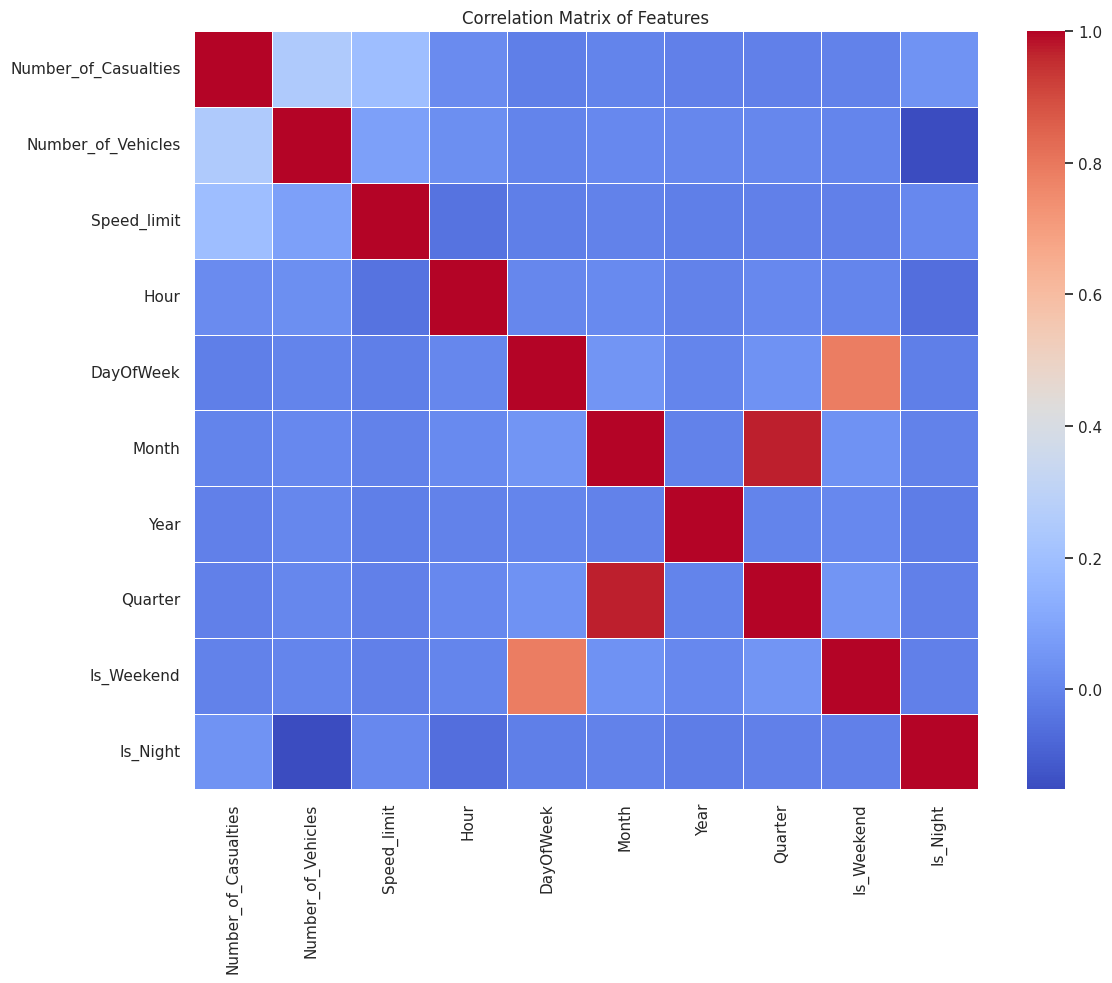

Dropped highly correlated features: ['Quarter']
Shape after dropping high-correlation features: (210266, 9)


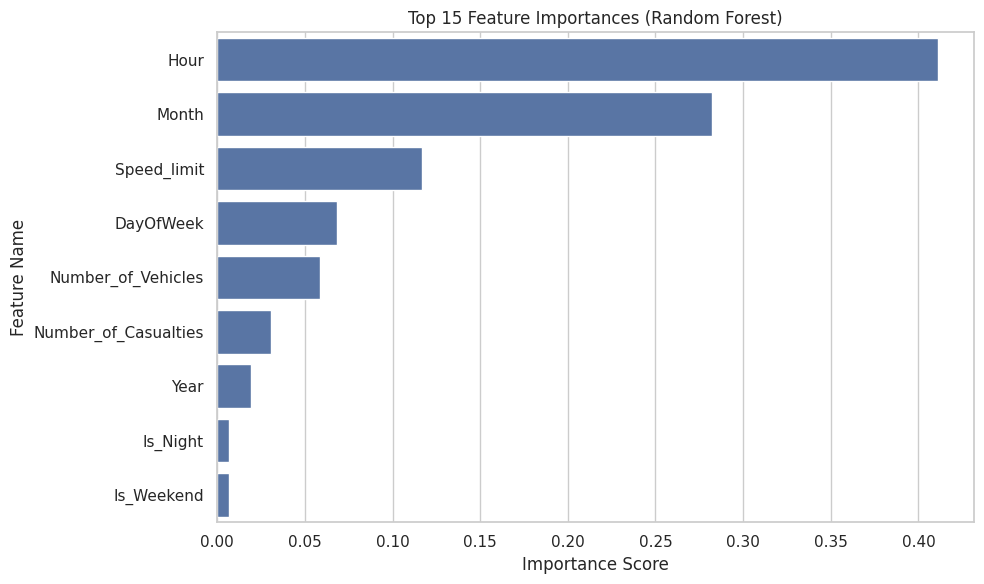

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# Step 1: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_resampled)

# Get retained feature names
selected_columns = X_resampled.columns[selector.get_support()]
X_resampled = pd.DataFrame(X_var, columns=selected_columns)

print("Remaining features after low-variance filtering:", X_resampled.shape[1])

# Step 2: Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = X_resampled.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

# Drop highly correlated features (|corr| > 0.9)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col].abs() > 0.9)]
X_resampled.drop(columns=high_corr_features, inplace=True)

print("Dropped highly correlated features:", high_corr_features)
print("Shape after dropping high-correlation features:", X_resampled.shape)

# Step 3: Feature importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

importances = rf_model.feature_importances_
feature_names = X_resampled.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Display class distribution in training set
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

# Display class distribution in testing set
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

# Display total number of records
print("\nTotal records after SMOTE:", len(y_resampled))
print("Training records:", len(y_train))
print("Testing records:", len(y_test))

X_train shape: (168212, 9)
y_train shape: (168212,)
X_test shape: (42054, 9)
y_test shape: (42054,)

Class distribution in training set:
Accident_Severity
1    50.0
0    50.0
Name: proportion, dtype: float64

Class distribution in testing set:
Accident_Severity
1    50.0
0    50.0
Name: proportion, dtype: float64

Total records after SMOTE: 210266
Training records: 168212
Testing records: 42054


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     21027
           1       0.87      0.81      0.84     21027

    accuracy                           0.84     42054
   macro avg       0.84      0.84      0.84     42054
weighted avg       0.84      0.84      0.84     42054

Accuracy: 0.8427


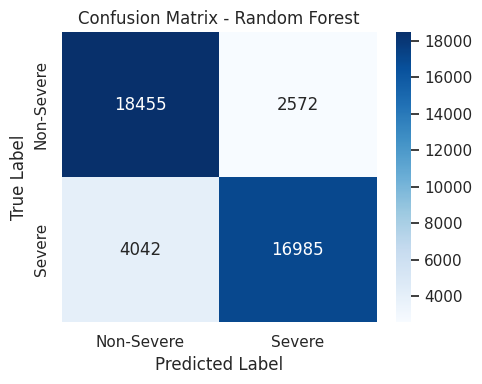

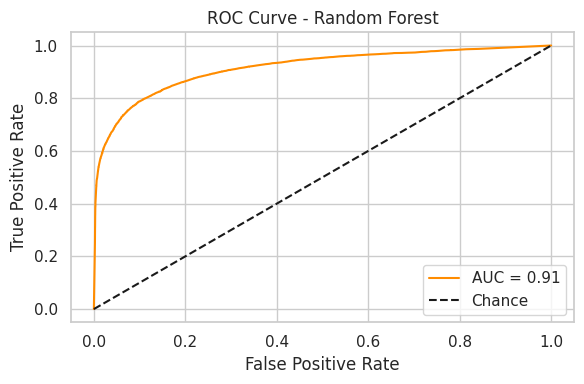

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Random Forest model =====
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred = rf_model.predict(X_test)                        # Predicted class labels
y_proba = rf_model.predict_proba(X_test)[:, 1]           # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy = accuracy_score(y_test, y_pred)                # Accuracy
mse = mean_squared_error(y_test, y_pred)                 # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)                # Mean Absolute Error
rmse = np.sqrt(mse)                                      # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc = roc_auc_score(y_test, y_proba)                 # Compute AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)                 # False positive rate and true positive rate

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.75      0.96      0.85     21027
           1       0.95      0.68      0.80     21027

    accuracy                           0.82     42054
   macro avg       0.85      0.82      0.82     42054
weighted avg       0.85      0.82      0.82     42054

Accuracy: 0.8237


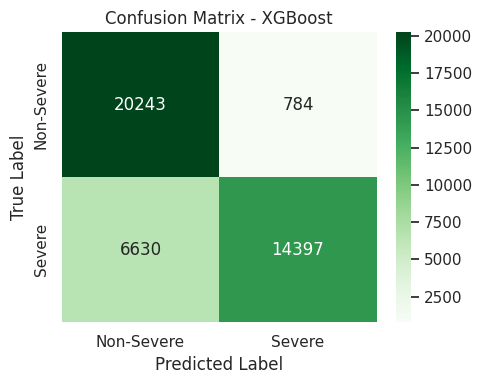

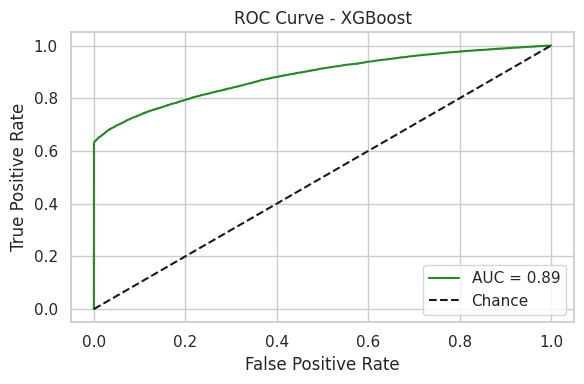

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the XGBoost model =====
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')  # Removed deprecated use_label_encoder
xgb_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_xgb = xgb_model.predict(X_test)                        # Predicted class labels
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]           # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)             # Accuracy
mse_xgb = mean_squared_error(y_test, y_pred_xgb)              # Mean Squared Error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)             # Mean Absolute Error
rmse_xgb = np.sqrt(mse_xgb)                                   # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_xgb:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)              # Compute AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)          # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_xgb:.2f}", color='forestgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     21027
           1       0.59      0.62      0.61     21027

    accuracy                           0.60     42054
   macro avg       0.60      0.60      0.60     42054
weighted avg       0.60      0.60      0.60     42054

Accuracy: 0.5954


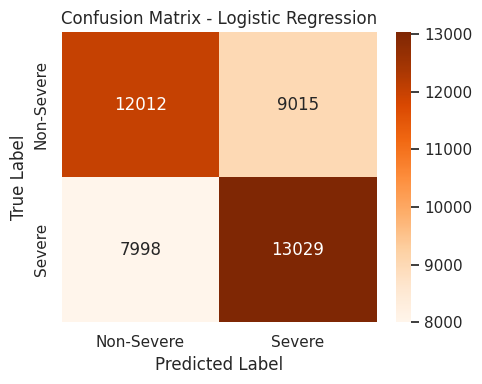

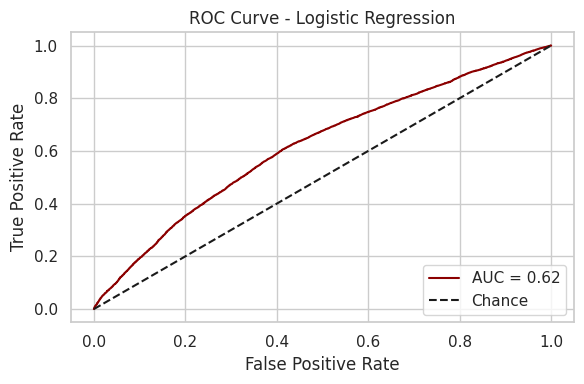

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Logistic Regression model =====
lr_model = LogisticRegression(random_state=42, max_iter=1000)   # Increase max_iter to avoid convergence warning
lr_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_lr = lr_model.predict(X_test)                            # Predicted class labels
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]               # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_lr = accuracy_score(y_test, y_pred_lr)                 # Accuracy
mse_lr = mean_squared_error(y_test, y_pred_lr)                  # Mean Squared Error
mae_lr = mean_absolute_error(y_test, y_pred_lr)                 # Mean Absolute Error
rmse_lr = np.sqrt(mse_lr)                                       # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test, y_pred_lr, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_lr:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)                  # Compute AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)              # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {roc_auc_lr:.2f}", color='darkred')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

=== Classification Report (Decision Tree) ===
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     21027
           1       0.86      0.80      0.83     21027

    accuracy                           0.84     42054
   macro avg       0.84      0.84      0.84     42054
weighted avg       0.84      0.84      0.84     42054

Accuracy: 0.8364


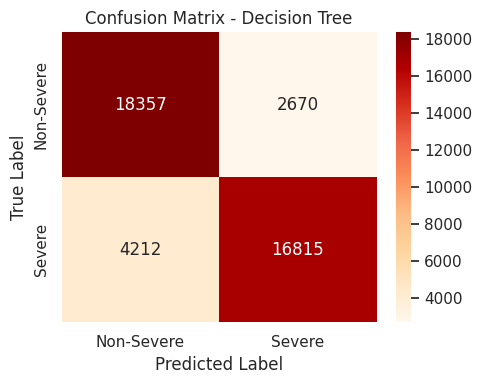

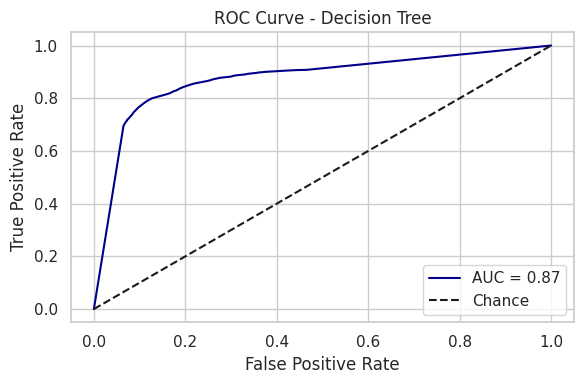

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Decision Tree model =====
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_dt = dt_model.predict(X_test)                         # Predicted class labels
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]            # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_dt = accuracy_score(y_test, y_pred_dt)              # Accuracy
mse_dt = mean_squared_error(y_test, y_pred_dt)               # Mean Squared Error
mae_dt = mean_absolute_error(y_test, y_pred_dt)              # Mean Absolute Error
rmse_dt = np.sqrt(mse_dt)                                    # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (Decision Tree) ===")
print(classification_report(y_test, y_pred_dt, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_dt:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)               # Compute AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)            # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {roc_auc_dt:.2f}", color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

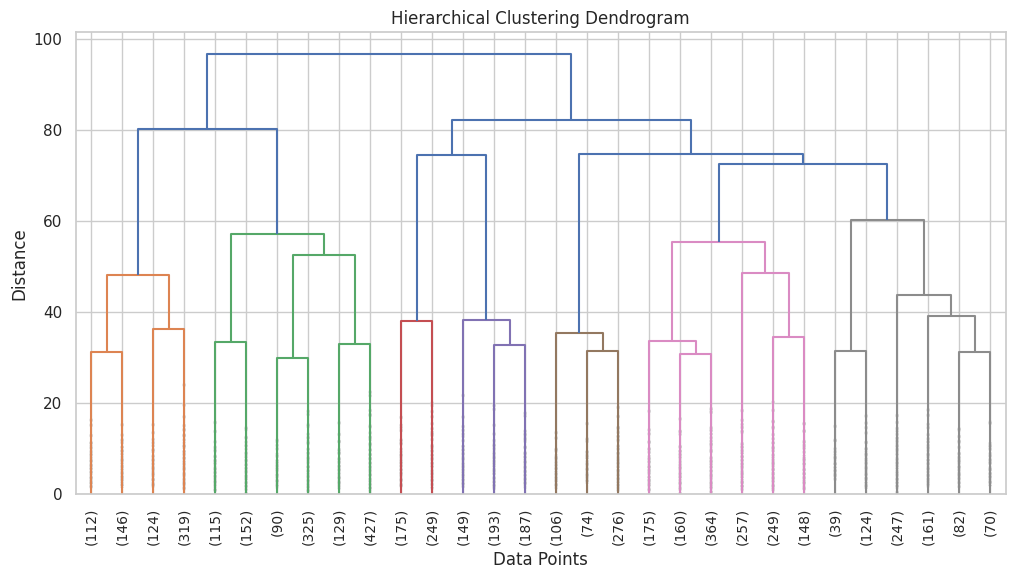

Cluster distribution:
 Cluster
3    2532
1    1939
2     953
Name: count, dtype: int64

Cluster-wise averages:
          Accident_Index  Accident Date  Day_of_Week  Junction_Control  \
Cluster                                                                 
1           2586.740588     369.789067     2.980918          3.491490   
2           2773.959077     380.463799     2.821616          3.508919   
3           2783.531991     359.214850     2.920616          3.526856   

         Junction_Detail  Accident_Severity   Latitude  Light_Conditions  \
Cluster                                                                    
1               4.598762           1.930892  52.769538          2.886024   
2               3.968520           1.889822  52.673002          3.459601   
3               3.435229           1.727488  52.396007          3.428515   

         Local_Authority_(District)  Carriageway_Hazards  ...  \
Cluster                                                   ...   
1          

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Road_Accidents_Data.csv')
# Drop rows with missing values
df_clean = df.dropna().copy()

# Encode categorical features if present
for col in df_clean.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Perform Hierarchical Clustering
linked = linkage(df_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90.,
           leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Form flat clusters (e.g., 3 clusters)
clusters = fcluster(linked, 3, criterion='maxclust')

# Add cluster labels
df_clean.loc[:, 'Cluster'] = clusters

# Cluster distribution
print("Cluster distribution:\n", df_clean['Cluster'].value_counts())

# Analyze cluster characteristics
print("\nCluster-wise averages:\n", df_clean.groupby('Cluster').mean(numeric_only=True))

# Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(df_scaled, clusters)

print("\n=== Evaluation Metrics ===")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

In [ ]:
from sklearn.metrics import v_measure_score, adjusted_rand_score

# Assuming the true labels are in a column called 'Accident_Severity'
# Replace with the actual ground truth column in your dataset
true_labels = df_clean['Accident_Severity']

# Compute V-measure and Adjusted Rand Index (ARI)
v_measure = v_measure_score(true_labels, clusters)
ari = adjusted_rand_score(true_labels, clusters)

print(f"V-measure Score: {v_measure:.3f}")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")


V-measure Score: 0.039
Adjusted Rand Index (ARI): -0.014


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Road_Accidents_Data.csv')
# --- Drop irrelevant ID columns if present ---
id_columns = ["Accident_ID", "ID", "AccidentNumber"]  # adjust based on your dataset
df = df.drop(columns=[col for col in id_columns if col in df.columns], errors="ignore")

# --- Identify target column ---
# Replace with the actual column name (check df.columns if unsure)
target_col = "Accident_Severity"

# --- One-hot encode categorical variables ---
df_encoded = pd.get_dummies(df, drop_first=True)

# --- Define features (X) and target (y) ---
X = df_encoded.drop(target_col, axis=1)
y = df[target_col]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Scale features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Train all models on same data ---
rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42, use_label_encoder=False)
log_model = LogisticRegression(max_iter=1000, random_state=42)

rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
log_model.fit(X_train, y_train)

models = {
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "XGBoost": xgb_model,
    "Logistic Regression": log_model
}

# --- Binarize labels for ROC (binary classification assumed) ---
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# --- Plot ROC curves ---
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# ===== Import Libraries =====
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)

# ===== Train Models =====
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric="logloss")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
dt_model = DecisionTreeClassifier(random_state=42)

# Fit models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# ===== Predictions & Probabilities =====
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# ===== ROC Curves & AUC =====
plt.figure(figsize=(7, 5))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='orange')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", color='green')

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color='red')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", color='blue')

# Chance Line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


ValueError: multiclass format is not supported

<Figure size 700x500 with 0 Axes>

In [ ]:
# --- Libraries ---
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Predict probabilities for each model
y_proba_lr = lr.predict_proba(X_test)
y_proba_rf = rf.predict_proba(X_test)
y_proba_dt = dt.predict_proba(X_test)

plt.figure(figsize=(8, 6))

# --- Logistic Regression ---
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_lr[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"LR (class {classes[i]}, AUC={roc_auc:.2f})", linestyle="--")

# --- Random Forest ---
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"RF (class {classes[i]}, AUC={roc_auc:.2f})", linestyle="-")

# --- Decision Tree ---
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"DT (class {classes[i]}, AUC={roc_auc:.2f})", linestyle=":")

# Plot settings
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multiclass Classification")
plt.legend(loc="lower right", fontsize=8)
plt.show()


NameError: name 'lr' is not defined

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


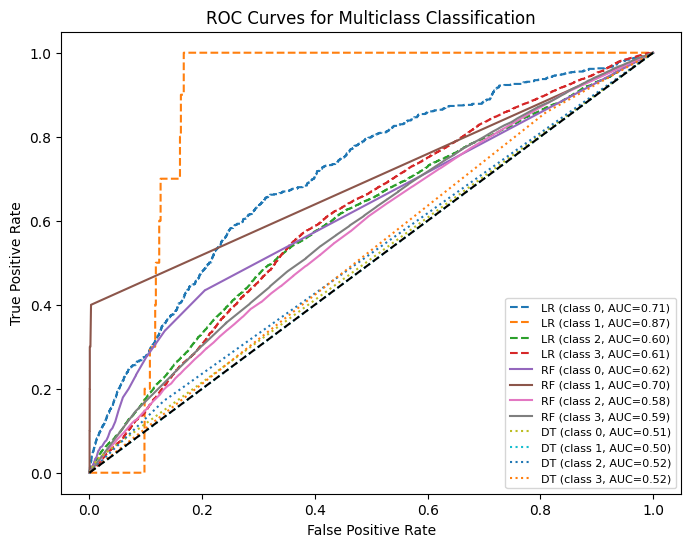

In [ ]:
# --- Libraries ---
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# --- Train/Test Split (assuming X, y are ready) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Models ---
lr = LogisticRegression(max_iter=500, multi_class="ovr")  # Logistic Regression
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest
dt = DecisionTreeClassifier(random_state=42)  # Decision Tree

# --- Fit Models ---
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)

# --- Binarize the output for multiclass ROC ---
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# --- Predict Probabilities ---
y_proba_lr = lr.predict_proba(X_test)
y_proba_rf = rf.predict_proba(X_test)
y_proba_dt = dt.predict_proba(X_test)

# --- ROC Curve Plot ---
plt.figure(figsize=(8, 6))

# Logistic Regression
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_lr[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle="--", label=f"LR (class {classes[i]}, AUC={roc_auc:.2f})")

# Random Forest
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle="-", label=f"RF (class {classes[i]}, AUC={roc_auc:.2f})")

# Decision Tree
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_dt[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle=":", label=f"DT (class {classes[i]}, AUC={roc_auc:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], "k--")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multiclass Classification")
plt.legend(loc="lower right", fontsize=8)
plt.show()
